
# Generalized Frangi with Multi-modal Fusion on FIND

This notebook illustrates all steps with formulas and figures.
- $\Sigma$: set of scales, σ: a single scale
- $\lambda_1, \lambda_2$: Hessian eigenvalues sorted so that $|\lambda_1| \le |\lambda_2$
- $\beta$, $c$, $c_\theta$: Frangi hyper-parameters
- $R$: pixel neighborhood radius; $K \in \{1,2\}$ controls triangle-connectivity


In [ ]:

# Install runtime deps (Colab-friendly)
!pip -q install numpy scipy scikit-image matplotlib joblib tqdm tqdm-joblib hdbscan networkx gdown tifffile imageio pandas Pillow pot


In [ ]:
%%bash
git clone https://github.com/Ludwig-H/Generalized-Frangi-for-Automatic-Crack-Extraction-on-FIND-dataset.git
cd Generalized-Frangi-for-Automatic-Crack-Extraction-on-FIND-dataset
pip install  .
cd ..

Processing /content/Generalized-Frangi-for-Automatic-Crack-Extraction-on-FIND-dataset
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for frangi-fusion: filename=frangi_fusion-0.1.0-py3-none-any.whl size=18555 sha256=b244219cfd112e3c4ef374943fa0227f3ddb346928c3d2baaa88348566b1ee9d
  Stored in directory: /root/.cache/pip/wheels/cf/4d/0b/07f466e36f5ccb3bee5b5dd1c8bb8f8557c5e10cfde7e5996b
Successfully built frangi-fusion
  Attempting uninstall: frangi-fusion
    Found existing installation: frangi-fusion 0.1.0
    Uninstalling frangi-fusion-0.1.0:
      Successfully uninstalled frangi-fusion-0.1.0


fatal: destination path 'Generalized-Frangi-for-Automatic-Crack-Extraction-on-FIND-dataset' already exists and is not an empty directory.


In [ ]:

import os, sys, numpy as np, matplotlib.pyplot as plt, random, zipfile, imageio, pandas as pd
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from skimage.morphology import binary_closing, binary_opening, disk

# Ensure local src is importable in Colab
repo_root = os.path.abspath("..")
if repo_root not in sys.path:
    sys.path.append(repo_root)

from frangi_fusion import (
    set_seed, auto_discover_find_structure, load_modalities_and_gt_by_index, to_gray_uint8,
    to_gray, compute_hessians_per_scale, fuse_hessians_per_scale,
    build_frangi_similarity_graph, distances_from_similarity, triangle_connectivity_graph,
    largest_connected_component, hdbscan_from_sparse,
    mst_on_cluster, kcenters_on_tree, paths_between_centers, skeleton_from_center_paths,
    overlay_hessian_orientation, show_clusters_on_image, animate_fault_growth,
    skeletonize_lee, thicken, jaccard_index, tversky_index, wasserstein_distance_skeletons
)



## 1) Download FIND via `gdown` then unzip

We fetch `data.zip` and unpack to `data_find/`.


In [ ]:
import gdown, zipfile, os

url = "https://drive.google.com/uc?id=1qnLMCeon7LJjT9H0ENiNF5sFs-F7-NvK"
zip_path = "data.zip"
extract_dir = "data_find"
fallback_folder_url = "https://drive.google.com/drive/folders/19lZyRzfMDcJpTMWxfgMNswgf8X4J3kZ5?usp=sharing"

os.makedirs(extract_dir, exist_ok=True)

try:
    # Tentative 1: téléchargement du ZIP puis unzip
    if not os.path.exists(zip_path):
        out = gdown.download(url, zip_path, quiet=False)
        if out is None or not os.path.exists(zip_path):
            raise RuntimeError("gdown did not retrieve the ZIP.")

    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(extract_dir)
    print("Unzipped to:", extract_dir)

except Exception as e:
    print("Primary download/unzip failed:", repr(e))
    print("Falling back to the public Drive folder (already unzipped)...")

    # Tentative 2: téléchargement récursif du dossier déjà dézippé
    # Remplit directement extract_dir
    try:
        # gdown >= 4.2.0
        gdown.download_folder(
            url=fallback_folder_url,
            output=extract_dir,
            quiet=False,
            use_cookies=False
        )
        print("Fallback synced to:", extract_dir)
    except Exception as e2:
        print("Fallback folder download failed:", repr(e2))
        raise


Unzipped to: data_find



## 2) Pick one image and show modalities

We select one index with a fixed seed ($=1234$).


Found: 2500 intensity, 2500 range, 2500 fused, 2500 filtered, 2500 labels.


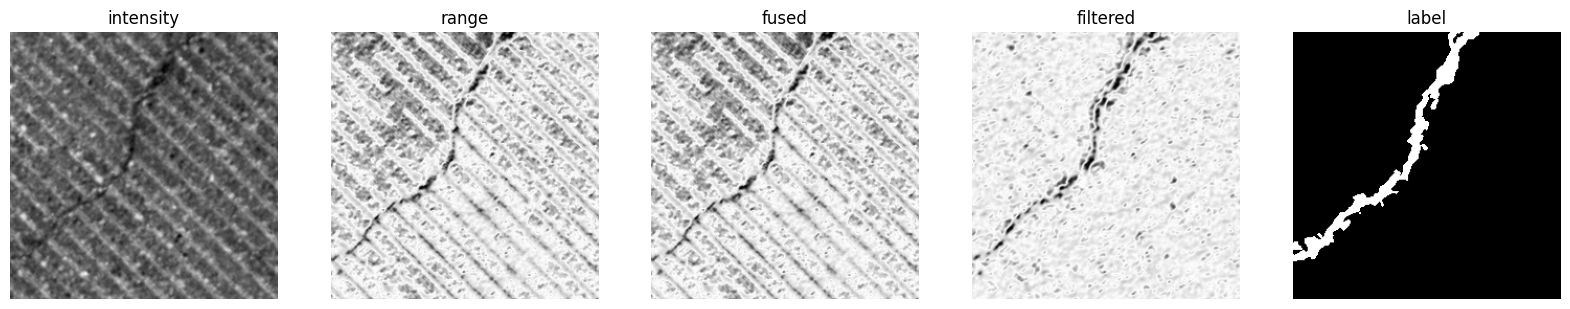

In [ ]:

seed = 1 # set_seed(1234)
struct = auto_discover_find_structure("data_find")
n_total = len(struct["label"]) if struct["label"] else len(struct["intensity"])
index = seed # random.Random(seed).randrange(max(1, n_total)) # or : index = ...
dat = load_modalities_and_gt_by_index(struct, index)

# Display modalities
cols = len(dat["arrays"])
plt.figure(figsize=(4*cols,4))
for i,(k,arr) in enumerate(dat["arrays"].items()):
    plt.subplot(1, cols, i+1); plt.title(k); plt.imshow(arr, cmap='gray'); plt.axis('off')
plt.show()
base = dat["arrays"].get("intensity", next(iter(dat['arrays'].values())))


In [ ]:
# struct


## 3) Parameters

- $\Sigma = \left\{ \sigma_m\right\}_{m=1}^M$: set of Gaussian scales  
- $\beta$, $c$, $c_\theta$: Frangi parameters  
- $R$: radius for pixel graph  
- $K \in \{1,2\}$: 1 = plain Frangi distances; 2 = add triangle-connectivity (Rips)


In [ ]:
Σ = [1,3,5,9]
β = 0.5
c = 0.25
c_θ = 0.125
R = 5
K = 1
dark_ridges = True  # cracks are valleys => λ2 ≥ 0 after our sign convention



## 4) Hessian per modality and per scale

For a grayscale image $I$, the Hessian at scale σ is:
$$
H_\sigma(I) =
\begin{pmatrix}
I_{xx} & I_{xy} \\\\
I_{xy} & I_{yy}
\end{pmatrix}
$$
with Gaussian derivatives and reflective borders.

We sort eigenvalues by absolute value at each pixel: $|\lambda_1| \le |\lambda_2|$.  
**Normalization:** for each σ we divide by $\max_{x,y} |\lambda_2(x,y)|$ so that $\lambda_1,\lambda_2 \in [-1,1]$.


In [ ]:

mods = {}
if "intensity" in dat["arrays"]:
    mods["intensity"] = compute_hessians_per_scale(to_gray(dat["arrays"]["intensity"]), Σ)
if "range" in dat["arrays"]:
    mods["range"] = compute_hessians_per_scale(to_gray(dat["arrays"]["range"]), Σ)
if "fused" in dat["arrays"]:
    mods["fused"] = compute_hessians_per_scale(to_gray(dat["arrays"]["fused"]), Σ)
if "filtered" in dat["arrays"]:
    mods["filtered"] = compute_hessians_per_scale(to_gray(dat["arrays"]["filtered"]), Σ)

weights = {"intensity": 0.5, "range":0.2, "filtered":0.3, "fused":0.} # {"intensity": 0.1, "range":0.8, "filtered":0.1, "fused":0.} #{k:1.0 for k in mods.keys()}
fused_H = fuse_hessians_per_scale(mods, weights)
print("Modalities fused:", list(mods.keys()))


Modalities fused: ['intensity', 'range', 'fused', 'filtered']



### Visualize: orientation-colored overlays and $|\lambda_2|$

We show $\theta$ (color hue) and strength (value). For $|\lambda_2|$ we select, per pixel, the $\sigma$ that maximizes $|\lambda_2|$.


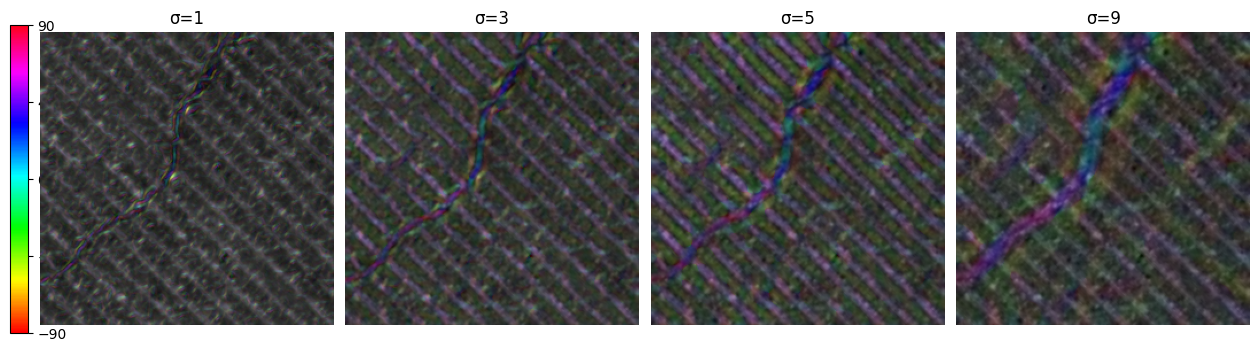

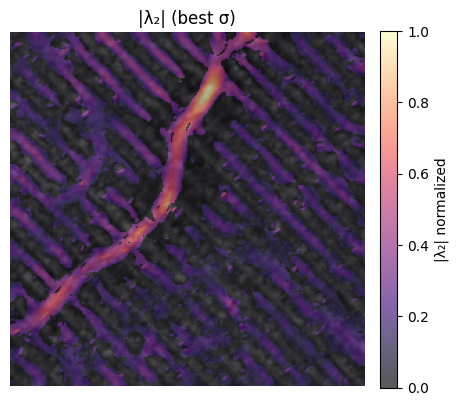

In [ ]:

# Single legend at left + 4 overlays
import matplotlib as mpl
fig = plt.figure(figsize=(16,4))
gs = fig.add_gridspec(nrows=1, ncols=5, width_ratios=[0.06,1,1,1,1], wspace=0.05)
cax = fig.add_subplot(gs[0,0])
sm = mpl.cm.ScalarMappable(cmap=mpl.cm.hsv, norm=mpl.colors.Normalize(vmin=-90, vmax=90))
cb = fig.colorbar(sm, cax=cax); cb.set_label("θ (deg)", fontsize=9); cb.set_ticks([-90,-45,0,45,90])
for i,Hd in enumerate(fused_H[:4]):
    ax = fig.add_subplot(gs[0,i+1])
    overlay = overlay_hessian_orientation(base, Hd, alpha=0.5)
    ax.imshow(overlay); ax.set_title(f"σ={Hd['sigma']}"); ax.axis('off')
plt.show()

# |λ2| at best scale
e2n_stack = np.stack([Hd['e2n'] for Hd in fused_H], axis=0)
abs_e2n_stack = np.abs(e2n_stack)
best_idx = abs_e2n_stack.argmax(axis=0)
e2n_best = np.take_along_axis(e2n_stack, best_idx[None,...], axis=0)[0]
plt.figure(figsize=(5,5)); plt.imshow(base, cmap='gray'); im=plt.imshow(np.clip(e2n_best,0,1), cmap='magma', alpha=0.65, vmin=0, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04, label="|λ₂| normalized"); plt.axis('off'); plt.title("|λ₂| (best σ)"); plt.show()



/tmp/ipython-input-2059659867.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


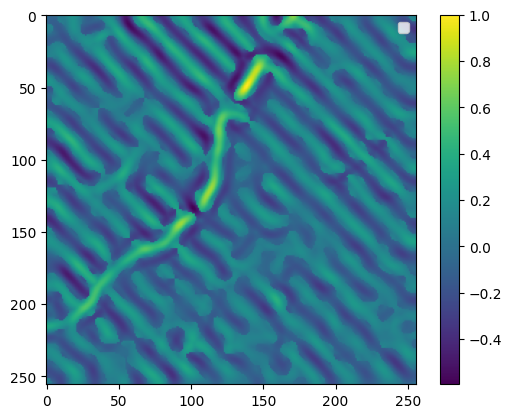

In [ ]:
plt.imshow(fused_H[2]['e2n'])
plt.colorbar()
plt.legend()


## 5) Frangi similarity graph $S$

For neighbor pixels $i,j$ within radius $R$, we define a similarity (Frangi-style):
$$
s(i,j)
= \exp\!\left(-\tfrac12\left(\tfrac{\left|{\frac{\lambda_{1,i}}{\lambda_{2,i}}}\right| + \left|{\frac{\lambda_{1,j}}{\lambda_{2,j}}}\right|}{\beta}\right)^2\right)
\left(1-\exp\!\left(-\tfrac12\left(\tfrac{\lvert \lambda_{2,i}\lambda_{2,j}\rvert}{c}\right)^2\right)\right)
\exp\!\left(-\tfrac12\left(\tfrac{\lvert \sin(\theta_i-\theta_j)\rvert}{c_\theta}\right)^2\right)
$$

~~We keep only valleys if `dark_ridges=True` (λ₂ ≥ 0).~~

We keep only large values: `v >= percentile(Frangi_response, threshold_mask)`.

Distances are
$$
\require{cancel}
{\texttt{mode="minus"}} {D = 1 - S}.$$
$$ {\texttt{mode="inverse"}} \xcancel{D = 1/S -1} $$
$$ {\texttt{mode="log"}} \xcancel{D = \sqrt{-\log(S)}} $$

In [ ]:

mode = "minus" # ["log", "minus", "inverse"]
threshold_mask = 0.80 # 0.80 pour K=1
coords, neighbors, S = build_frangi_similarity_graph(fused_H, β, c, c_θ, R, candidate_mask=None, threshold_mask=threshold_mask, dark_ridges=dark_ridges) # threshold_mask = quantile we throw
D = distances_from_similarity(S, mode)
print("Graph:", D.shape, "nnz:", D.nnz)


Graph: (49152, 49152) nnz: 2093494



## 6) Triangle-connectivity ($K=2$, optionnal)

We connect edges via Vietoris–Rips triangles (filtration = max of edge distances).


In [ ]:

if K==2:
    D = triangle_connectivity_graph(coords, D)
    print("After triangle‑connectivity:", D.shape, "nnz:", D.nnz)


After triangle‑connectivity: (49152, 49152) nnz: 295956



## 7) Largest connected component


In [ ]:

D_cc, idx_nodes = largest_connected_component(D)
sub_coords = coords[idx_nodes]
print("Largest CC:", D_cc.shape[0], "nodes.")


Largest CC: 153 nodes.



## 8) Sparse HDBSCAN on CSR distances (no densification)

We compute **core distances** from sparse neighbors, **mutual reachability**, the **MST**, and apply a simplified **EOM** selection.

`expZ` is the exponent used for preprocessing the radius $r$ in the distance matrix (used to compute the *stability* $\hat \lambda$ in `excess of mass`EOM method):
$$ r \mapsto r^{\texttt{expZ}}$$


Clusters: [0] . 'Noise': 0


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


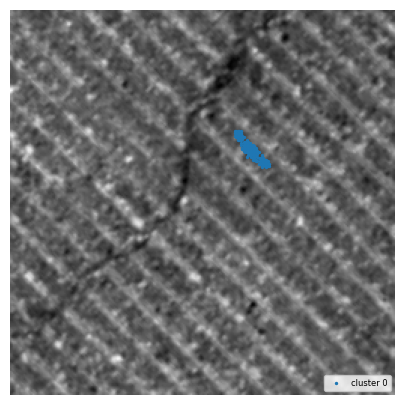

In [ ]:
import hdbscan

expZ = 1

Dist = D_cc.copy()
Dist.data = Dist.data ** expZ
Dist = Dist.tocsr()
Dist.setdiag(0.0)
min_cluster_size = 512
max_dist = 1
min_samples = 1
allow_single_cluster = True
# labels = hdbscan_from_sparse(Dist, min_cluster_size=200, min_samples=5, allow_single_cluster=True, expZ=expZ)
clusterer = hdbscan.HDBSCAN(
    metric="precomputed",
    min_cluster_size=min_cluster_size,
    min_samples=min_samples,
    max_dist=max_dist,
    allow_single_cluster=allow_single_cluster,
)
labels = clusterer.fit_predict(Dist)
print("Clusters:", np.unique(labels),". 'Noise':", np.sum(labels == -1))
show_clusters_on_image(base, sub_coords, labels, figsize=(5,5))



## 9) MST + k-centers + exact MST paths → skeleton

We set $k = \max(3, N/500)$ where $N$ is the number of nodes in a cluster. The final skeleton is the union of all MST paths between the $k$-centers.


In [ ]:

from frangi_fusion.mst_kcenters import mst_on_cluster, kcenters_on_tree, paths_between_centers, skeleton_from_center_paths
all_fault_edges = []
uniq = np.unique(labels)
for lab in uniq:
    if lab < 0: continue
    cl = np.where(labels==lab)[0]
    if cl.size < 3: continue
    mst = mst_on_cluster(D_cc, cl)
    k = max(3, int(cl.size/500))
    centers = kcenters_on_tree(mst, k, objective="max")
    paths = paths_between_centers(mst, centers)
    segs = skeleton_from_center_paths(paths, sub_coords[cl], mst)
    if segs.shape[0]>0: all_fault_edges.append(segs)
fault_edges = np.vstack(all_fault_edges) if all_fault_edges else np.zeros((0,5), dtype=np.float32)
print("Skeleton segments:", fault_edges.shape)


Skeleton segments: (46, 5)



### Visualize skeleton on the base image


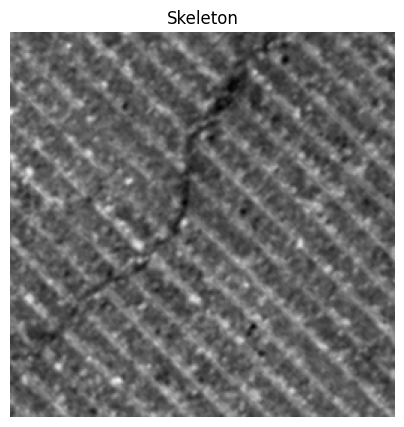

In [ ]:
τ = 0.9

H,W = base.shape[:2]
overlay = np.dstack([base,base,base]).astype(np.float32)
for e in fault_edges[fault_edges[:,-1] <= τ]: # fault_edges:
    r0,c0,r1,c1,w = e
    rr = np.linspace(r0, r1, num=int(max(abs(r1-r0),abs(c1-c0))+1)).astype(int)
    cc = np.linspace(c0, c1, num=rr.shape[0]).astype(int)
    rr = np.clip(rr, 0, H-1); cc = np.clip(cc, 0, W-1)
    overlay[rr,cc,0]=255; overlay[rr,cc,1]=0; overlay[rr,cc,2]=0
plt.figure(figsize=(5,5)); plt.imshow(overlay.astype(np.uint8)); plt.axis('off'); plt.title("Skeleton"); plt.show()



## 10) Filtration per pixel

For each pixel \(i\) in the CC, the filtration value is $\min_j d(i,j)$ over its neighbors.


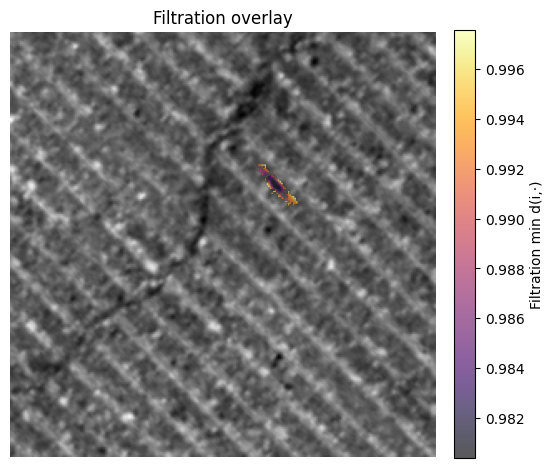

In [ ]:

n = D_cc.shape[0]
indptr, indices, data = D_cc.indptr, D_cc.indices, D_cc.data
filtration = np.full(n, np.inf, dtype=np.float64)
for i in range(n):
    row = data[indptr[i]:indptr[i+1]]
    if row.size>0: filtration[i] = float(row.min())
fmap = np.full(base.shape[:2], np.nan, dtype=np.float32)
rr,cc = sub_coords[:,0], sub_coords[:,1]
fmap[rr,cc] = filtration.astype(np.float32)
vmin = np.nanpercentile(fmap,5); vmax = np.nanpercentile(fmap,95)
plt.figure(figsize=(6,6)); plt.imshow(base, cmap='gray')
im = plt.imshow(np.ma.masked_invalid(fmap), cmap='inferno', alpha=0.65, vmin=vmin, vmax=vmax)
plt.colorbar(im, fraction=0.046, pad=0.04, label="Filtration min d(i,·)")
plt.axis('off'); plt.title("Filtration overlay"); plt.show()



## 11) Thresholded graph (τ = 0.8) and metrics vs GT

We thicken fragments to compare skeletons more robustly. Metrics: **Jaccard**, **Tversky** (α=1, β=0.5), **Wasserstein**.


Jaccard: 0.0 Tversky: 0.0 Wasserstein: 3030.0


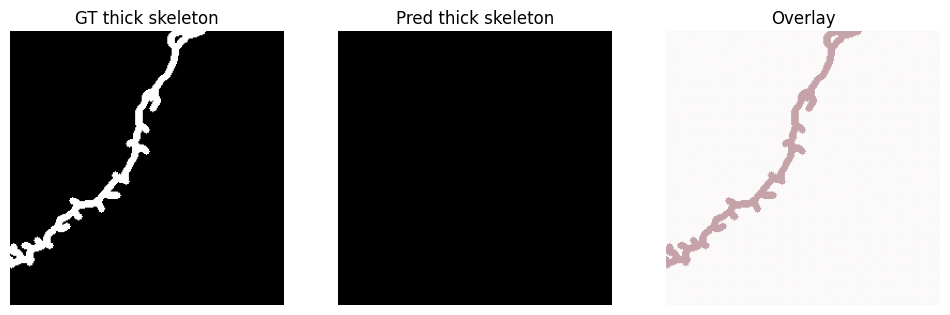

In [ ]:

épaisseur_trait = 3 # pixels
diam_affin = 3
mask = np.zeros_like(base, dtype=np.uint8)
for e in fault_edges[fault_edges[:,-1] <= τ]:
    r0,c0,r1,c1,w = e
    rr = np.linspace(r0, r1, num=int(max(abs(r1-r0),abs(c1-c0))+1)).astype(int)
    cc = np.linspace(c0, c1, num=rr.shape[0]).astype(int)
    rr = np.clip(rr, 0, base.shape[0]-1); cc = np.clip(cc, 0, base.shape[1]-1)
    mask[rr,cc] = 1

sk_pred = skeletonize_lee(mask); sk_pred = thicken(sk_pred, pixels=épaisseur_trait)
gt = (dat["arrays"].get("label", np.zeros_like(base)) > 0).astype(np.uint8)

if diam_affin > 0:
    gt = binary_closing(gt, footprint=disk(diam_affin)).astype(np.uint8)
    gt = binary_opening(gt, footprint=disk(diam_affin)).astype(np.uint8)

sk_gt = skeletonize_lee(gt); sk_gt = thicken(sk_gt, pixels=épaisseur_trait)

jac = jaccard_index(sk_pred, sk_gt)
tvs = tversky_index(sk_pred, sk_gt, alpha=1.0, beta=0.5)
wass = wasserstein_distance_skeletons(sk_pred, sk_gt)
print("Jaccard:", jac, "Tversky:", tvs, "Wasserstein:", wass)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("GT thick skeleton"); plt.imshow(sk_gt, cmap='gray'); plt.axis('off')
plt.subplot(1,3,2); plt.title("Pred thick skeleton"); plt.imshow(sk_pred, cmap='gray'); plt.axis('off')
plt.subplot(1,3,3); plt.title("Overlay");
plt.imshow(sk_gt*255, cmap='Reds', alpha=0.7); plt.imshow(sk_pred*255, cmap='Blues', alpha=0.5); plt.axis('off')
plt.show()


# Batch Processing on Drive (Images 1-500)


In [ ]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


MessageError: Error: credential propagation was unsuccessful

In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import hdbscan
import itertools
from joblib import Parallel, delayed
from tqdm_joblib import tqdm_joblib

# --- Configuration ---
# Process images 1 to 500 (indices 0 to 499)
start_idx = 0
end_idx = 500
n_jobs = 8 # Parallel CPUs

# # Parameters (same as example)
# Σ = [1,3,5,9]
# β = 0.5
# c = 0.25
# c_θ = 0.125
# R = 5
# K = 1
# dark_ridges = True
# mode = "minus"
# threshold_mask = 0.80
# expZ = 1
# min_cluster_size = 512
# min_samples = 1
# max_dist = 1
# allow_single_cluster = True
# τ = 0.9
# weights = {"intensity": 0.7, "range":0.1, "filtered":0.2, "fused":0.}
# épaisseur_trait = 3
# diam_affin = 2

# --- Output Directory Setup ---
# Construct folder name with parameters
weights_str = f"I{weights.get('intensity',0)}_R{weights.get('range',0)}_F{weights.get('filtered',0)}_Fu{weights.get('fused',0)}"
params_str = f"K{K}_beta{β}_c{c}_ct{c_θ}_R{R}_tau{τ}_ExhaustivePolarity"
folder_name = f"{weights_str}_{params_str}"

# Base path on Drive
base_output_dir = "/content/drive/MyDrive/Datasets/FIND/Results"
output_dir = os.path.join(base_output_dir, folder_name)
skeletons_dir = os.path.join(output_dir, "skeletons")
overlay_dir = os.path.join(output_dir, "overlays")

print(f"Results will be saved to: {output_dir}")
if not os.path.exists(skeletons_dir):
    os.makedirs(skeletons_dir, exist_ok=True)
if not os.path.exists(overlay_dir):
    os.makedirs(overlay_dir, exist_ok=True)

# --- Worker Function ---
def process_image_idx(idx):
    try:
        # Ensure necessary imports inside worker if needed (though cloudpickle handles most)
        # Note: 'struct' must be available in the scope or passed.
        # In Colab/Jupyter + joblib, global vars from the notebook usually pickle fine.

        # 1. Load Data
        dat = load_modalities_and_gt_by_index(struct, idx)
        base = dat["arrays"].get("intensity", next(iter(dat['arrays'].values())))
        img_name = f"im{idx+1:05d}"

        # Prepare GT
        gt_raw = dat["arrays"].get("label", np.zeros_like(base))
        gt = (gt_raw > 0).astype(np.uint8)

        if 'diam_affin' not in globals(): diam_affin = 2
        if diam_affin > 0:
            gt = binary_closing(gt, footprint=disk(diam_affin)).astype(np.uint8)
            gt = binary_opening(gt, footprint=disk(diam_affin)).astype(np.uint8)

        sk_gt = skeletonize_lee(gt)
        sk_gt_thick = thicken(sk_gt, pixels=épaisseur_trait)

        # 2. Pre-compute Hessians
        valid_mods = [k for k in ["intensity", "range", "filtered", "fused"] if k in dat["arrays"] and weights[k] > 0]
        hessian_cache = {}

        for mod in valid_mods:
            arr = dat["arrays"][mod]
            h_norm = compute_hessians_per_scale(to_gray(arr), Σ)
            arr_inv = 255 - arr
            h_inv = compute_hessians_per_scale(to_gray(arr_inv), Σ)
            hessian_cache[mod] = [h_norm, h_inv]

        # 3. Exhaustive combinations
        combo_indices = list(itertools.product([0, 1], repeat=len(valid_mods)))

        best_tversky = -1.0
        best_metrics = {
            "Image": img_name,
            "Jaccard": 0.0,
            "Tversky": 0.0,
            "Wasserstein": 0.0,
            "Best_Combo": ""
        }
        best_sk_img = None

        for combo in combo_indices:
            current_mods = {}
            combo_str_parts = []
            for i, mod in enumerate(valid_mods):
                choice = combo[i]
                current_mods[mod] = hessian_cache[mod][choice]
                combo_str_parts.append(f"{mod[0]}:{'Inv' if choice else 'Norm'}")

            combo_desc = "|".join(combo_str_parts)

            fused_H = fuse_hessians_per_scale(current_mods, weights)

            coords, neighbors, S = build_frangi_similarity_graph(
                fused_H, β, c, c_θ, R,
                candidate_mask=None, threshold_mask=threshold_mask, dark_ridges=dark_ridges
            )
            D = distances_from_similarity(S, mode)

            if K == 2:
                D = triangle_connectivity_graph(coords, D)

            D_cc, idx_nodes = largest_connected_component(D)
            sk_pred = np.zeros_like(base, dtype=np.uint8)

            if D_cc.shape[0] > 0:
                sub_coords = coords[idx_nodes]

                Dist = D_cc.copy()
                Dist.data = Dist.data ** expZ
                Dist = Dist.tocsr()
                Dist.setdiag(0.0)

                clusterer = hdbscan.HDBSCAN(
                    metric="precomputed",
                    min_cluster_size=min_cluster_size,
                    min_samples=min_samples,
                    max_dist=max_dist,
                    allow_single_cluster=allow_single_cluster,
                )
                labels = clusterer.fit_predict(Dist)

                all_fault_edges = []
                uniq = np.unique(labels)
                for lab in uniq:
                    if lab < 0: continue
                    cl = np.where(labels==lab)[0]
                    if cl.size < 3: continue

                    mst = mst_on_cluster(D_cc, cl)
                    k_val = max(3, int(cl.size/500))
                    centers = kcenters_on_tree(mst, k_val, objective="max")
                    paths = paths_between_centers(mst, centers)
                    segs = skeleton_from_center_paths(paths, sub_coords[cl], mst)
                    if segs.shape[0] > 0:
                        all_fault_edges.append(segs)

                if all_fault_edges:
                    fault_edges = np.vstack(all_fault_edges)
                    mask = np.zeros_like(base, dtype=np.uint8)
                    for e in fault_edges[fault_edges[:,-1] <= τ]:
                        r0,c0,r1,c1,w = e
                        rr = np.linspace(r0, r1, num=int(max(abs(r1-r0),abs(c1-c0))+1)).astype(int)
                        cc = np.linspace(c0, c1, num=rr.shape[0]).astype(int)
                        rr = np.clip(rr, 0, base.shape[0]-1)
                        cc = np.clip(cc, 0, base.shape[1]-1)
                        mask[rr,cc] = 1
                    sk_pred = skeletonize_lee(mask)

            sk_pred_thick = thicken(sk_pred, pixels=épaisseur_trait)
            tvs = tversky_index(sk_pred_thick, sk_gt_thick, alpha=1.0, beta=0.5)

            if tvs > best_tversky:
                best_tversky = tvs
                jac = jaccard_index(sk_pred_thick, sk_gt_thick)
                wass = wasserstein_distance_skeletons(sk_pred_thick, sk_gt_thick)
                best_metrics = {
                    "Image": img_name,
                    "Jaccard": jac,
                    "Tversky": tvs,
                    "Wasserstein": wass,
                    "Best_Combo": combo_desc
                }
                best_sk_img = Image.fromarray((sk_pred * 255).astype(np.uint8))
                best_sk_pred_thick = sk_pred_thick

        plt.title("Overlay");
        plt.imshow(sk_gt_thick*255, cmap='Reds', alpha=0.7); plt.imshow(best_sk_pred_thick*255, cmap='Blues', alpha=0.5); plt.axis('off')
        # Save the overlay image
        plt.savefig(os.path.join(overlay_dir, f"{img_name}_overlay.png"))
        plt.show()
        # Clear the current figure to prevent plots from accumulating in memory
        plt.clf()
        print(f"Best metrics {img_name} :", best_metrics)
        # Save Best Image immediately
        if best_sk_img is not None:
            best_sk_img.save(os.path.join(skeletons_dir, f"{img_name}_skeleton.png"))
        else:
            Image.new('L', (base.shape[1], base.shape[0])).save(os.path.join(skeletons_dir, f"{img_name}_skeleton.png"))

        return best_metrics

    except Exception as e:
        # Return error info but don't crash main loop
        return {
            "Image": f"im{idx+1:05d}",
            "Jaccard": np.nan, "Tversky": np.nan, "Wasserstein": np.nan, "Best_Combo": f"ERROR: {e}"
        }

# --- Batch Processing ---
print(f"Starting parallel batch processing for images {start_idx+1} to {end_idx} using {n_jobs} jobs...")
print("Note: Processing 16 combinations (normal/inverted) per image.")

with tqdm_joblib(tqdm(desc="Progress", total=end_idx-start_idx)) as progress_bar:
    metrics_data = Parallel(n_jobs=n_jobs)(
        delayed(process_image_idx)(i) for i in range(start_idx, end_idx)
    )

# --- Save Summary CSV ---
df = pd.DataFrame(metrics_data)
if not df.empty:
    mean_vals = df[["Jaccard", "Tversky", "Wasserstein"]].mean()
    mean_row = pd.DataFrame([{
        "Image": "AVERAGE",
        "Jaccard": mean_vals["Jaccard"],
        "Tversky": mean_vals["Tversky"],
        "Wasserstein": mean_vals["Wasserstein"],
        "Best_Combo": "-"
    }])
    df = pd.concat([df, mean_row], ignore_index=True)

csv_path = os.path.join(output_dir, "metrics_summary.csv")
df.to_csv(csv_path, index=False)
print(f"Saved metrics summary to {csv_path}")
print("Averages:")
print(mean_vals if not df.empty else "No data")

# Results


In [ ]:
import os

results_base_dir = '/content/drive/MyDrive/Datasets/FIND/Results'

# List all items in the base directory
all_items = os.listdir(results_base_dir)

# Filter to keep only directories
result_dirs = [item for item in all_items if os.path.isdir(os.path.join(results_base_dir, item))]

print(f"Found {len(result_dirs)} subdirectories in '{results_base_dir}':")
for d in result_dirs:
    print(f"- {d}")

In [ ]:
import pandas as pd

metrics_summary = []

for d in result_dirs:
    folder_path = os.path.join(results_base_dir, d)
    csv_path = os.path.join(folder_path, 'metrics_summary.csv')

    if os.path.exists(csv_path):
        df_metrics = pd.read_csv(csv_path)
        average_row = df_metrics[df_metrics['Image'] == 'AVERAGE']

        if not average_row.empty:
            # Extract relevant metrics and folder name
            jaccard = average_row['Jaccard'].values[0]
            tversky = average_row['Tversky'].values[0]
            wasserstein = average_row['Wasserstein'].values[0]

            metrics_summary.append({
                'Configuration': d,
                'Jaccard': jaccard,
                'Tversky': tversky,
                'Wasserstein': wasserstein
            })
    else:
        print(f"Warning: 'metrics_summary.csv' not found in {d}")

# Compile the results into a single DataFrame
summary_df = pd.DataFrame(metrics_summary)

print("Compiled metrics summary:")
print(summary_df)

In [ ]:
summary_df_sorted = summary_df.sort_values(by='Tversky', ascending=False)
print("Sorted metrics summary by Tversky index (descending):")
print(summary_df_sorted)